# Assignment 1 2AMM10 2023-2024

## Group: Way Too Deep

### Member 1: Aniket Mishra

### Member 2: Anindita Sarkar

### Member 3: Mario Trabert


In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub


# add additonal imports here
class FashionDataset(Dataset):
    def __init__(
        self, csv_file, img_dir, column_class="articleTypeId", transform=None
    ):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(
            self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg"
        )  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

## Importing more libraries cuz y not


In [4]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch.nn as nn
from typing import Tuple, List, Dict, Optional, Type, Any
from torch import optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import time
from matplotlib import cm

import torch.multiprocessing

torch.multiprocessing.set_start_method("spawn", force=True)

from dataset import FashionDataset
from datetime import datetime


Download data with kagglehub


In [5]:
# dataset_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/datasets/"

In [6]:
# Stores images in kaggle cache folder
dataset_path = kagglehub.dataset_download(
    "paramaggarwal/fashion-product-images-small"
)
img_dir = os.path.join(dataset_path, "images")
print(f"Stored dataset files at {dataset_path}")

Stored dataset files at /home/ubuntu/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1


The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.


In [7]:
# local_data_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/dataset"
cwd = os.getcwd()
local_data_path = os.path.join(cwd, "dataset") # Assumes you are running this from Assignment_1 folder
print(local_data_path)

/home/ubuntu/dev/tue/dl/2AMM15_Deep_Learning/Assighment_1/dataset


In [8]:
dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
)

In [9]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


In [10]:
dataset.df

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0
...,...,...,...,...,...
35929,13398,Shirts,Topwear,1,0
35930,53734,Casual Shoes,Shoes,2,1
35931,11033,Tops,Topwear,6,0
35932,22334,Tshirts,Topwear,0,0


In [11]:
# I assume this is just data exploration?
# Lets delete this or keep it out of commits cause it confuses me
print(dataset.img_dir)
print(dataset.df["imageId"].min())
print(dataset[0])
print(len(set(dataset.targets)))


/home/ubuntu/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images
1163
(<PIL.Image.Image image mode=RGB size=60x80 at 0x7F4D4C252780>, 15)
39


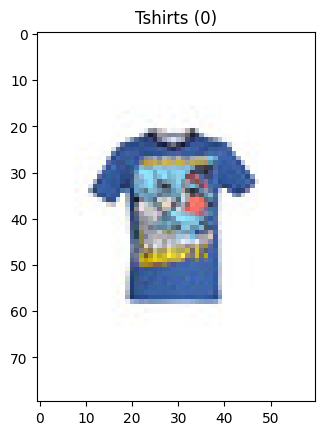

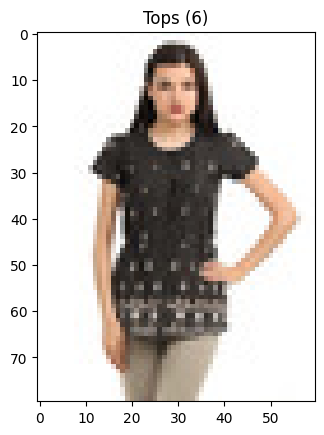

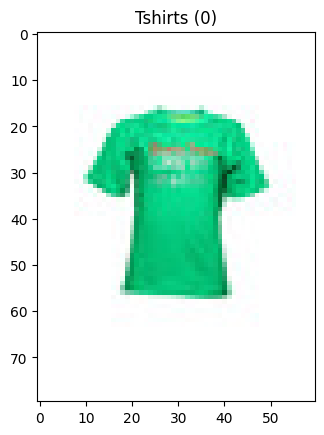

In [12]:
np.random.seed(42)
# np.random.seed(69) # lol
random_indices = np.random.choice(len(dataset), 3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"] + f" ({label.item()})")
    plt.imshow(img)
    plt.show()

In [13]:
# Setting up default values, I forget to change them everywhere
batch_size = 64
learning_rate = 0.0001
all_birbs = sorted(list(set(dataset.targets)))
num_classes = len(set(dataset.targets))

resize_pixels_x = 128
resize_pixels_y = 128
crop_size = 128
num_epochs = 25

In [14]:
# Temp setup
batch_size = 32
resize_pixels_x = 96
resize_pixels_y = 96
crop_size = 96
num_epochs = 25  # temporarily for test run

In [15]:
# Data augmentation and normalization
# Training data
transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.RandomResizedCrop(
            crop_size
        ),  # Crop yoinks stuff completely, gotta skip ig?
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(
            (-15, 15), interpolation=InterpolationMode.NEAREST
        ),  # Rotate +-15 degrees cuz not text, we can
        transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.2),
        # Data Augmentation - end
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

# Test data
test_transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

## Loading different datasets


In [16]:
# transform = transforms.Compose([...])  # your image transformations
train_dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
    transform=transform,
)
main_test_dataset = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    transform=test_transform,
)
new_test_dataset = FashionDataset(
    f"{local_data_path}/new_test.csv",
    img_dir,
    transform=test_transform,
)
main_support_dataset = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    transform=test_transform,
)
new_support_dataset = FashionDataset(
    f"{local_data_path}/new_support.csv",
    img_dir,
    transform=test_transform,
)
merged_test_dataset = FashionDataset(
    f"{local_data_path}/merged_test.csv",
    img_dir,
    transform=test_transform,
)  # merged corresponds to main+new
merged_support_dataset = FashionDataset(
    f"{local_data_path}/merged_support.csv",
    img_dir,
    transform=test_transform,
)

# datasets with categories
main_test_dataset_cat = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)
main_support_dataset_cat = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)


label_id_to_label_name = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i][
        "articleTypeName"
    ].iloc[0]
    for i in range(39)
}
label_id_to_label_name.update(
    {
        i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i][
            "articleTypeName"
        ].iloc[0]
        for i in range(39, 39 + 30)
    }
)

## Task 1


In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()

        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCNN2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNetCNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)

        self.layer1 = ResidualBlock(16, 32, downsample=False)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        # self.layer4 = ResidualBlock(128, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)

        self.dropout = nn.Dropout(0.1)

        with torch.no_grad():
            # dummy_input = torch.zeros(1, in_channels, 128, 128)
            dummy_input = torch.zeros(1, in_channels, resize_pixels_x, resize_pixels_y)
            x = self.conv1(dummy_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            # x = self.layer4(x)
            x = self.layer4(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_embeddings(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


print("ResNet CNN2 defined")

ResNet CNN2 defined


In [18]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)
print(torch.version.xpu)

cuda
None


In [20]:
model = ResNetCNN2(in_channels=3, num_classes=num_classes)
model = model.to(device)
model

ResNetCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): Ba

In [21]:
# Optional: Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs


In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score # 
import time
import matplotlib.pyplot as plt # For plotting loss and accuracy


In [23]:
# num_epochs = 25
# num_epochs = 60

print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Optional: Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs


Using device: cuda
Number of classes: 39
Batch size: 32
Learning rate: 0.0001


In [24]:
import os
cpu_count = os.cpu_count()
cpu_count

16

Train loader: 1123 batches, 35934 samples
Test loader: 63 batches, 1997 samples

Starting training...
Epoch [1/25], Step [280/1123], Batch Loss: 2.3684
Epoch [1/25], Step [560/1123], Batch Loss: 1.6289
Epoch [1/25], Step [840/1123], Batch Loss: 1.7932
Epoch [1/25], Step [1120/1123], Batch Loss: 1.6465
Epoch [1/25] completed in 88.25s:
  Training Loss: 2.1632, Training Accuracy: 38.02%
  Test Loss: 1.2015, Test Accuracy: 63.29%, Test Balanced Accuracy: 49.54%
Epoch [2/25], Step [280/1123], Batch Loss: 1.6150
Epoch [2/25], Step [560/1123], Batch Loss: 1.5179
Epoch [2/25], Step [840/1123], Batch Loss: 1.4641
Epoch [2/25], Step [1120/1123], Batch Loss: 1.2462
Epoch [2/25] completed in 70.06s:
  Training Loss: 1.5334, Training Accuracy: 53.39%
  Test Loss: 0.9057, Test Accuracy: 71.36%, Test Balanced Accuracy: 60.92%
Epoch [3/25], Step [280/1123], Batch Loss: 1.1450
Epoch [3/25], Step [560/1123], Batch Loss: 0.9274
Epoch [3/25], Step [840/1123], Batch Loss: 1.3192
Epoch [3/25], Step [1120/1

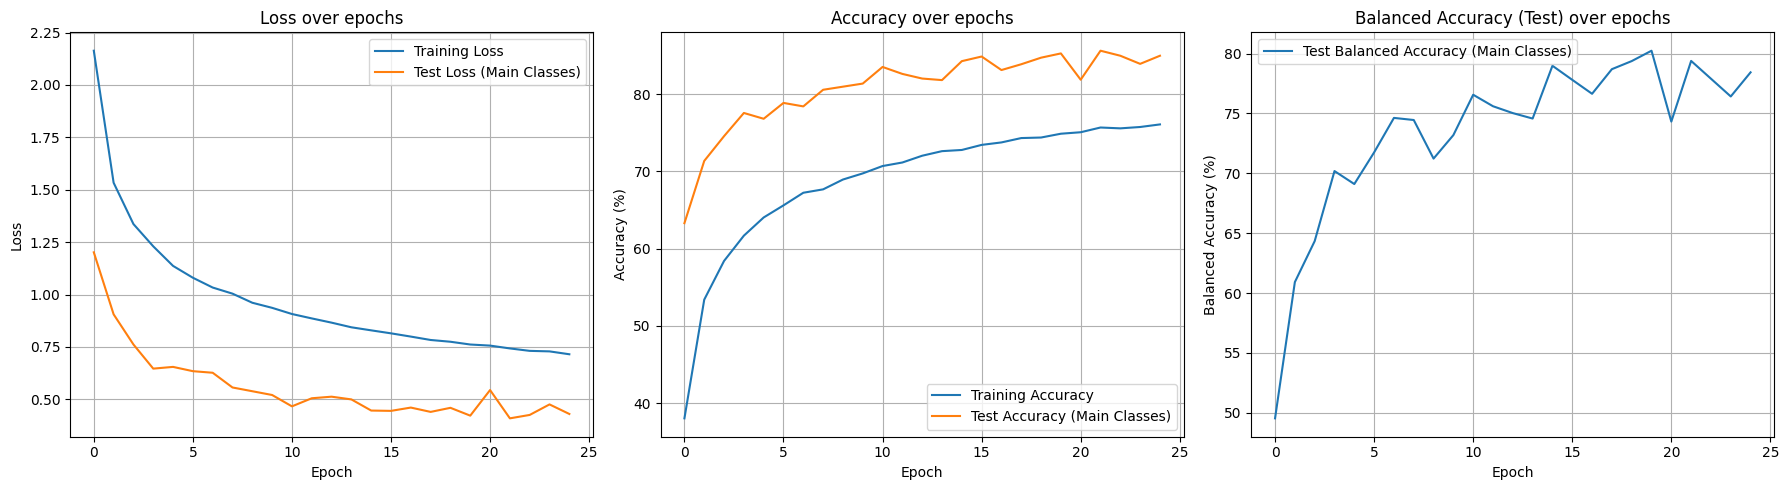

In [69]:
if 'train_dataset' not in locals() or 'main_test_dataset' not in locals():
	print("Please ensure train_dataset and main_test_dataset are defined.")
else:
	train_loader = DataLoader(
		dataset=train_dataset,
		batch_size=batch_size,
		shuffle=True,
		num_workers=max(cpu_count-1, 2), # Safe fallback
		pin_memory=True if device in ["cuda", "mps"] else False
	)

	test_loader = DataLoader(
		dataset=main_test_dataset, 
		batch_size=batch_size,
		shuffle=False,
		num_workers=max(cpu_count-1, 2), # Safe fallback
		pin_memory=True if device == ["cuda", "mps"] else False
	)

	print(f"Train loader: {len(train_loader)} batches, {len(train_loader.dataset)} samples")
	print(f"Test loader: {len(test_loader)} batches, {len(test_loader.dataset)} samples")


	train_losses = []
	test_losses = []
	train_accuracies = []
	test_accuracies = []
	test_balanced_accuracies = []

	print("\nStarting training...")
	for epoch in range(num_epochs):
		model.train()  # Set model to training mode
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		epoch_start_time = time.time()

		for i, (images, labels) in enumerate(train_loader):
			images = images.to(device)
			labels = labels.to(device)

			# Forward pass
			outputs = model(images)
			loss = criterion(outputs, labels)

			# Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch

			# Training accuracy for the batch
			_, predicted = torch.max(outputs.data, 1)
			total_train += labels.size(0)
			correct_train += (predicted == labels).sum().item()

			if (i + 1) % (len(train_loader) // 4) == 0 and i != 0 : # Print progress a few times per epoch
					print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
						f"Batch Loss: {loss.item():.4f}")

		epoch_loss = running_loss / total_train
		epoch_acc = 100 * correct_train / total_train
		train_losses.append(epoch_loss)
		train_accuracies.append(epoch_acc)

		# if 'scheduler' in locals():
		#     scheduler.step()

		model.eval()
		correct_test = 0
		total_test = 0
		running_test_loss = 0.0
		all_test_preds = []
		all_test_labels = []

		with torch.no_grad(): # Disable gradient calculations for evaluation
			for images, labels in test_loader:
				images = images.to(device)
				labels = labels.to(device)

				outputs = model(images)
				loss = criterion(outputs, labels)
				running_test_loss += loss.item() * images.size(0)

				_, predicted = torch.max(outputs.data, 1)
				total_test += labels.size(0)
				correct_test += (predicted == labels).sum().item()
				all_test_preds.extend(predicted.cpu().numpy())
				all_test_labels.extend(labels.cpu().numpy())

		epoch_test_loss = running_test_loss / total_test
		epoch_test_acc = 100 * correct_test / total_test
		epoch_test_balanced_acc = balanced_accuracy_score(all_test_labels, all_test_preds) * 100

		test_losses.append(epoch_test_loss)
		test_accuracies.append(epoch_test_acc)
		test_balanced_accuracies.append(epoch_test_balanced_acc)

		epoch_end_time = time.time()
		epoch_duration = epoch_end_time - epoch_start_time

		print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
		print(f"  Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
		print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%, Test Balanced Accuracy: {epoch_test_balanced_acc:.2f}%")
		if epoch_test_acc >= 75 and epoch_test_balanced_acc >= 75:
			print(f"  Performance target reached on main classes test set at epoch {epoch+1}!")


	print("\nFinished Training.")

	plt.figure(figsize=(18, 5))

	plt.subplot(1, 3, 1)
	plt.plot(train_losses, label="Training Loss")
	plt.plot(test_losses, label="Test Loss (Main Classes)")
	plt.title("Loss over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 2)
	plt.plot(train_accuracies, label="Training Accuracy")
	plt.plot(test_accuracies, label="Test Accuracy (Main Classes)")
	plt.title("Accuracy over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Accuracy (%)")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 3)
	plt.plot(test_balanced_accuracies, label="Test Balanced Accuracy (Main Classes)")
	plt.title("Balanced Accuracy (Test) over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Balanced Accuracy (%)")
	plt.legend()
	plt.grid(True)


	os.makedirs("outputs/images", exist_ok=True)
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")

	# Save training plots as image
	plot_save_path = f"outputs/images/training_curves_{timestamp}.png"
	plt.savefig(plot_save_path)
  
	plt.tight_layout()
	plt.show()

	os.makedirs("outputs/models", exist_ok=True)
	torch.save(model.state_dict(), f"outputs/models/resnetcnn2_task1_{timestamp}.pth")
	# model_save_path = "fashion_resnet_cnn2_task1_final.pth"
	# torch.save(model.state_dict(), model_save_path)
	# print(f"Model saved to {model_save_path}")


Saving dem models ez


In [57]:
os.makedirs("outputs/models", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_path = "outputs/models"
file_name = f"resnetcnn2_task1_{timestamp}.pth"
torch.save(model.state_dict(), os.path.join(save_path, file_name))
print(f"Model saved as {file_name} to {save_path}")

Model saved as resnetcnn2_task1_20250525_1546.pth to outputs/models


## Task 2


In [25]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [26]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


In [27]:
model = ResNetCNN2(in_channels=3, num_classes=39)  # same as original
model.load_state_dict(torch.load("outputs/models/resnetcnn2_task1_20250525_1758.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready for Task 2")


Model loaded and ready for Task 2


In [28]:
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
import torch
import numpy as np
import tqdm


def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)


def classify_with_support(query_embeddings, support_embeddings, support_labels, k=1):
    distances = torch.cdist(query_embeddings, support_embeddings)  # shape: [N_query, N_support]
    topk_indices = distances.topk(k, largest=False).indices       # shape: [N_query, k]
    topk_labels = support_labels[topk_indices]                    # shape: [N_query, k]
    pred_labels = torch.mode(topk_labels, dim=1).values
    return pred_labels


def evaluate_with_support(model, support_dataset, test_dataset, device, batch_size=512, k=1):
    support_loader = DataLoader(support_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    support_embeddings, support_labels = extract_embeddings(model, support_loader, device)
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)

    pred_labels = classify_with_support(test_embeddings, support_embeddings, support_labels, k)

    acc = (pred_labels == test_labels).float().mean().item() * 100
    bal_acc = balanced_accuracy_score(test_labels.numpy(), pred_labels.numpy()) * 100
    return acc, bal_acc


In [29]:
print("\nEvaluating Task 2 Scenarios...\n")

scenarios = {
    "Scenario 1 (Train support → Main test)": (train_dataset, main_test_dataset),
    "Scenario 2 (Main support → Main test)": (main_support_dataset, main_test_dataset),
    "Scenario 3 (New support → New test)": (new_support_dataset, new_test_dataset),
    "Scenario 4 (Merged support → Merged test)": (merged_support_dataset, merged_test_dataset),
}

for name, (support_set, test_set) in scenarios.items():
    acc, bal_acc = evaluate_with_support(model, support_set, test_set, device)
    print(f"{name}:")
    print(f"  Accuracy:         {acc:.2f}%")
    print(f"  Balanced Accuracy:{bal_acc:.2f}%\n")

    scenario_id = name.split("(")[0].strip().replace(" ", "_").lower()
    model_save_path = f"outputs/models/resnetcnn2_task2_{scenario_id}.pth"
    
    # Save model state dict
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}\n")



Evaluating Task 2 Scenarios...

Scenario 1 (Train support → Main test):
  Accuracy:         81.12%
  Balanced Accuracy:75.85%

Saved model to outputs/models/resnetcnn2_task2_scenario_1.pth

Scenario 2 (Main support → Main test):
  Accuracy:         80.92%
  Balanced Accuracy:75.92%

Saved model to outputs/models/resnetcnn2_task2_scenario_2.pth

Scenario 3 (New support → New test):
  Accuracy:         81.87%
  Balanced Accuracy:82.00%

Saved model to outputs/models/resnetcnn2_task2_scenario_3.pth

Scenario 4 (Merged support → Merged test):
  Accuracy:         74.87%
  Balanced Accuracy:70.08%

Saved model to outputs/models/resnetcnn2_task2_scenario_4.pth



## Task 3


In [30]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset  # Is this a typo meant to say merged_support_dataset?

In [31]:
# Task 3: Feature-Based Recommendation System
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

TOP_K = 3
CONFIDENCE_THRESHOLD = 0.4

def precision_at_k(retrieved_labels, true_label, k=None):
    """
    Computes Precision@k.
    If k is None, use full length of retrieved_labels.
    """
    if k is None:
        k = len(retrieved_labels)
    correct = sum(1 for i in range(k) if retrieved_labels[i] == true_label)
    return correct / k

def unnormalize(tensor_img):
    """
    Converts a normalized tensor image in [-1, 1] range back to [0, 1] for plotting.
    This is essentially a helper function that averts redundant output during plot creation.
    """
    return tensor_img * 0.5 + 0.5  # inverse of Normalize(mean=0.5, std=0.5)

# Extract embeddings for all support images
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels, indices = [], [], []
    with torch.no_grad():
        for i, (images, lbls) in enumerate(dataloader):
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
            # Save the true DataFrame indices
            indices.extend(dataloader.dataset.df.index[i * dataloader.batch_size : i * dataloader.batch_size + len(lbls)])
    return torch.cat(embeddings), torch.cat(labels), indices


# Visualize query image and top-k recommendations
def visualize_recommendations(query_img, rec_imgs, query_title="Query", rec_titles=None):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(rec_imgs) + 1, 1)
    plt.imshow(unnormalize(query_img.permute(1, 2, 0)))
    plt.title(query_title)
    plt.axis("off")
    
    for i, img in enumerate(rec_imgs):
        plt.subplot(1, len(rec_imgs) + 1, i + 2)
        plt.imshow(unnormalize(img.permute(1, 2, 0)))
        title = f"Top-{i+1}" if rec_titles is None else rec_titles[i]
        plt.title(title)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


# Run recommendation for one query image
def recommend_similar_images(model, query_dataset, support_dataset, device, k=3, support_idx_mapping=None, threshold=0.2):
    support_loader = DataLoader(support_dataset, batch_size=128, shuffle=False)
    support_embeddings, support_labels, _ = extract_embeddings(model, support_loader, device)

    idx = np.random.randint(0, len(query_dataset))
    query_img, query_label = query_dataset[idx]
    query_label = query_label.item() if torch.is_tensor(query_label) else int(query_label)
    query_img_input = query_img.unsqueeze(0).to(device)
    query_embedding = model.get_embeddings(query_img_input).cpu()

    distances = torch.cdist(query_embedding, support_embeddings)[0]
    topk = torch.topk(distances, k=k, largest=False)
    topk_indices = topk.indices

    softmax_confs_all = F.softmax(-distances, dim=0)
    softmax_confs_topk = softmax_confs_all[topk_indices]
    max_conf = softmax_confs_topk.max().item()

    rec_imgs, rec_labels, titles = [], [], []
    for i, sc in zip(topk_indices, softmax_confs_topk):
        true_idx = support_idx_mapping[i.item()]
        img, label = support_dataset[true_idx]
        rec_imgs.append(img)
        rec_labels.append(int(label))
        titles.append(f"Label: {label}\nConf: {sc:.2f}")

    # Always show selected images
    visualize_recommendations(query_img, rec_imgs, rec_titles=titles)

    # Decision print
    if max_conf < threshold:
        print(f"Recommendation NOT shown to user (confidence {max_conf:.2f} < threshold {threshold:.2f})")
    else:
        print(f"Recommendation shown to user (confidence {max_conf:.2f} ≥ threshold {threshold:.2f})")

    # Show details
    print(f"Query label: {query_label} - {label_id_to_label_name[query_label]}")
    print(f"Top-{k} recommended labels: {[f'{l} - {label_id_to_label_name[l]}' for l in rec_labels]}")
    print(f"Confidence scores: {[round(c.item(), 3) for c in softmax_confs_topk]}")

    # Correctness
    correct = int(query_label in rec_labels)
    print(f"Correct recommendation: {'Yes' if correct else 'No'}")




# Wrapper to run multiple recommendation tests
def run_recommendation_system(model, query_dataset, support_dataset, device, k=3, num_queries=5, seed=42):
    """
    Runs and visualizes recommendations for num_queries random queries.
    """
    np.random.seed(seed)

    # Build index mapping for support set
    support_idx_mapping = list(support_dataset.df.index)

    print(f"\nSupport set size: {len(support_idx_mapping)}")

    for i in range(num_queries):
        print(f"\nRecommendation #{i+1}")
        recommend_similar_images(
            model=model,
            query_dataset=query_dataset,
            support_dataset=support_dataset,
            device=device,
            k=k,
            support_idx_mapping=support_idx_mapping,
            threshold=CONFIDENCE_THRESHOLD
        )



Support set size: 3655

Recommendation #1


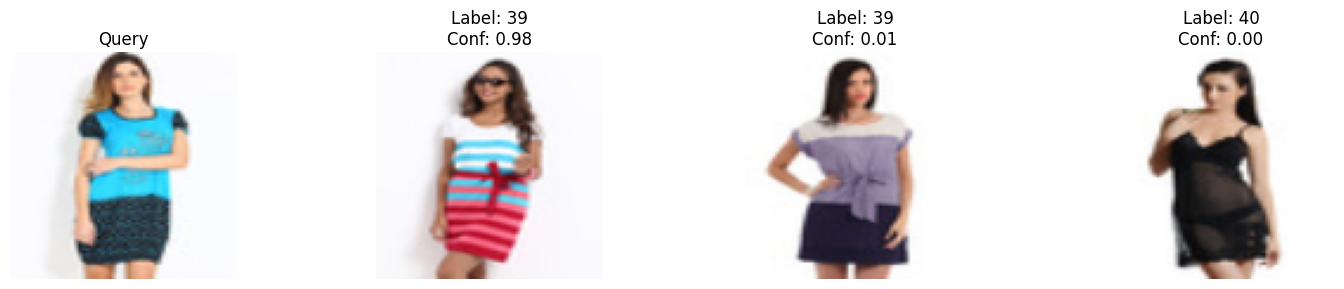

Recommendation shown to user (confidence 0.98 ≥ threshold 0.40)
Query label: 40 - Nightdress
Top-3 recommended labels: ['39 - Tunics', '39 - Tunics', '40 - Nightdress']
Confidence scores: [0.977, 0.014, 0.003]
Correct recommendation: Yes

Recommendation #2


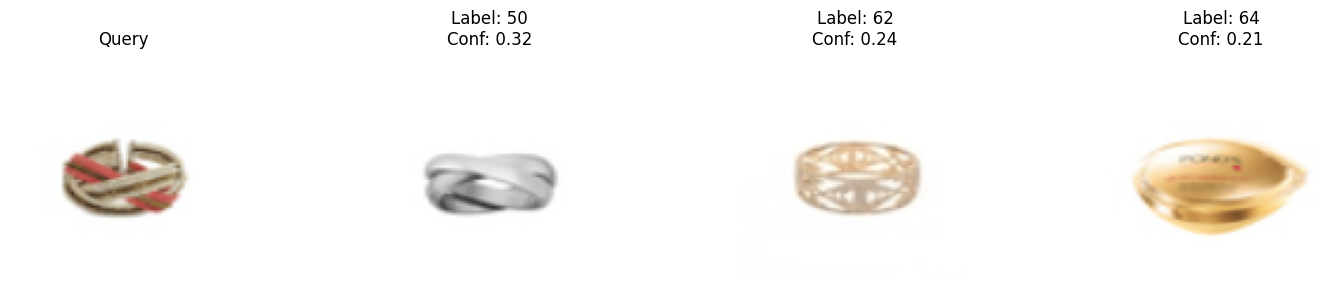

Recommendation NOT shown to user (confidence 0.32 < threshold 0.40)
Query label: 58 - Bangle
Top-3 recommended labels: ['50 - Ring', '62 - Bracelet', '64 - Face Moisturisers']
Confidence scores: [0.316, 0.244, 0.208]
Correct recommendation: No

Recommendation #3


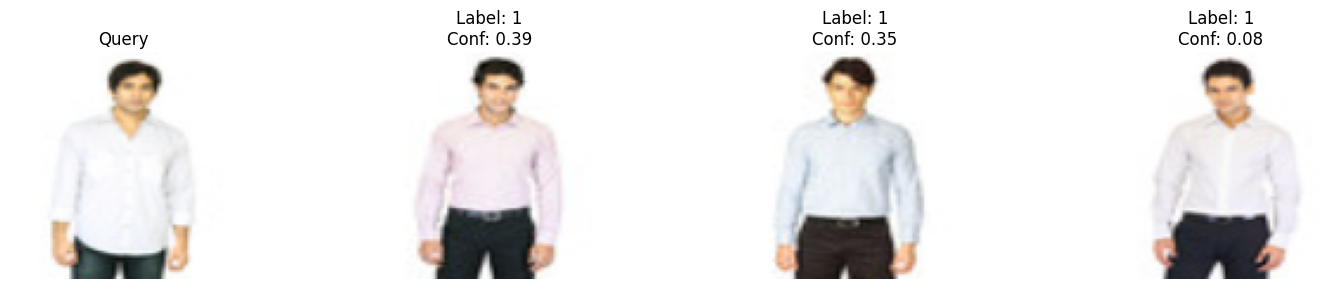

Recommendation NOT shown to user (confidence 0.39 < threshold 0.40)
Query label: 1 - Shirts
Top-3 recommended labels: ['1 - Shirts', '1 - Shirts', '1 - Shirts']
Confidence scores: [0.393, 0.346, 0.083]
Correct recommendation: Yes

Recommendation #4


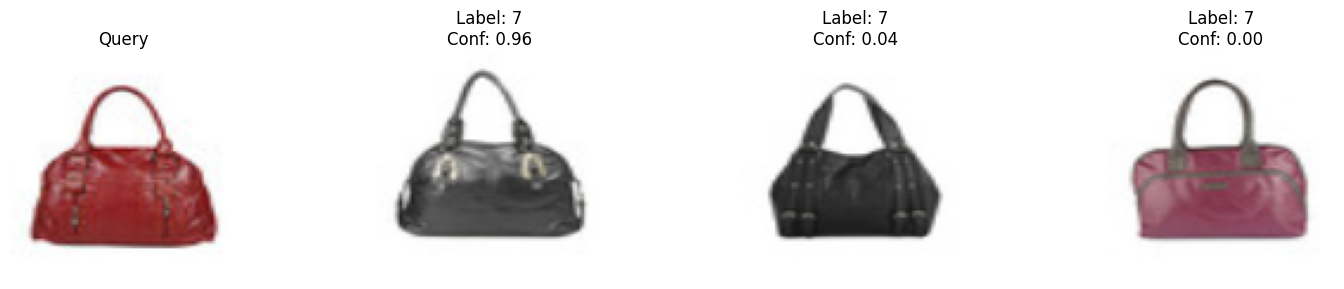

Recommendation shown to user (confidence 0.96 ≥ threshold 0.40)
Query label: 7 - Handbags
Top-3 recommended labels: ['7 - Handbags', '7 - Handbags', '7 - Handbags']
Confidence scores: [0.956, 0.042, 0.001]
Correct recommendation: Yes

Recommendation #5


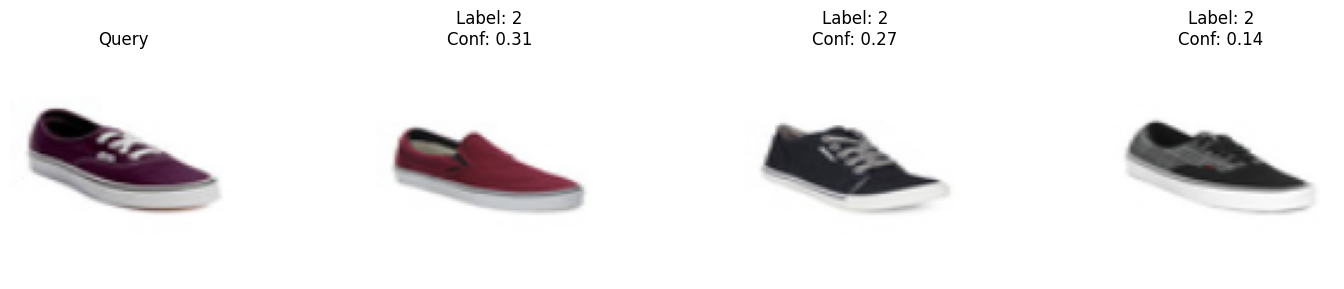

Recommendation NOT shown to user (confidence 0.31 < threshold 0.40)
Query label: 2 - Casual Shoes
Top-3 recommended labels: ['2 - Casual Shoes', '2 - Casual Shoes', '2 - Casual Shoes']
Confidence scores: [0.307, 0.274, 0.142]
Correct recommendation: Yes


In [32]:
run_recommendation_system(
    model=model,
    query_dataset=merged_test_dataset,
    support_dataset=merged_support_dataset,
    device=device,
    k=TOP_K,
    num_queries=5
)



In [33]:
import csv

def evaluate_recommendation_system(
    model,
    query_dataset,
    support_dataset,
    device,
    thresholds=None,
    num_queries=100,
    k=3
):
    """
    Evaluate the recommendation system over different confidence thresholds.

    For each query:
        - Retrieve top-k most similar items from the support set (catalog)
        - Use softmax-based confidence
        - Only recommend if max confidence >= threshold
        - Consider the recommendation correct if ≥1 item matches query class

    Plot error rate (%) vs. coverage (%)
    """

    if thresholds is None:
        thresholds = np.linspace(0.0, 0.9, 10)

    support_loader = DataLoader(support_dataset, batch_size=128, shuffle=False)
    support_embeddings, _, _ = extract_embeddings(model, support_loader, device)
    support_idx_mapping = list(support_dataset.df.index)

    error_rates_percent = []
    coverages_percent = []

    for threshold in thresholds:
        num_displayed = 0
        num_correct = 0

        for _ in range(num_queries):
            idx = np.random.randint(0, len(query_dataset))
            query_img, query_label = query_dataset[idx]
            query_label = query_label.item() if torch.is_tensor(query_label) else int(query_label)
            query_img_input = query_img.unsqueeze(0).to(device)
            query_embedding = model.get_embeddings(query_img_input).cpu()

            distances = torch.cdist(query_embedding, support_embeddings)[0]
            topk = torch.topk(distances, k=k, largest=False)
            topk_indices = topk.indices

            # Compute softmax confidence over support set
            softmax_conf_all = F.softmax(-distances, dim=0)
            topk_conf = softmax_conf_all[topk_indices]
            max_conf = topk_conf.max().item()

            # Decision: only show recommendation if confidence is high enough
            if max_conf >= threshold:
                num_displayed += 1
                # Get labels of top-k retrieved items
                retrieved_labels = [int(support_dataset[support_idx_mapping[i.item()]][1]) for i in topk_indices]
                # Mark as correct if ANY matches the query label
                if query_label in retrieved_labels:
                    num_correct += 1

        # Error rate (in %) = wrong / displayed
        if num_displayed > 0:
            error_rate = 100 * (1 - (num_correct / num_displayed))
        else:
            error_rate = 0.0  # No recommendations → 0% error (by definition)

        # Coverage (in %) = displayed / total queries
        coverage = 100 * (num_displayed / num_queries)

        error_rates_percent.append(error_rate)
        coverages_percent.append(coverage)

        print(f"Threshold: {threshold:.2f} | Error Rate: {error_rate:.1f}% | Coverage: {coverage:.1f}%")

    # Save results to CSV
    os.makedirs("outputs/evaluation", exist_ok=True)
    csv_path = os.path.join("outputs/evaluation", "task3_error_vs_coverage.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Threshold", "Error Rate (%)", "Coverage (%)"])
        for t, e, c in zip(thresholds, error_rates_percent, coverages_percent):
            writer.writerow([round(t, 2), round(e, 1), round(c, 1)])

    print(f"\nResults saved to: {csv_path}")


    # Plot
    plt.figure(figsize=(8, 6))
    sorted_points = sorted(zip(error_rates_percent, coverages_percent))
    x, y = zip(*sorted_points)
    plt.plot(x, y, marker='o')
    plt.xlabel("Error Rate (%)")
    plt.ylabel("Coverage (%)")
    plt.title("Error Rate vs. Coverage (Recommendation System)")
    plt.grid(True)
    plt.show()


Threshold: 0.00 | Error Rate: 12.6% | Coverage: 100.0%
Threshold: 0.10 | Error Rate: 13.2% | Coverage: 100.0%
Threshold: 0.20 | Error Rate: 12.6% | Coverage: 98.9%
Threshold: 0.30 | Error Rate: 12.0% | Coverage: 94.8%
Threshold: 0.40 | Error Rate: 12.9% | Coverage: 84.6%
Threshold: 0.50 | Error Rate: 9.8% | Coverage: 74.4%
Threshold: 0.60 | Error Rate: 10.0% | Coverage: 60.4%
Threshold: 0.70 | Error Rate: 9.8% | Coverage: 50.9%
Threshold: 0.80 | Error Rate: 8.9% | Coverage: 40.5%
Threshold: 0.90 | Error Rate: 9.1% | Coverage: 28.8%

Results saved to: outputs/evaluation/task3_error_vs_coverage.csv


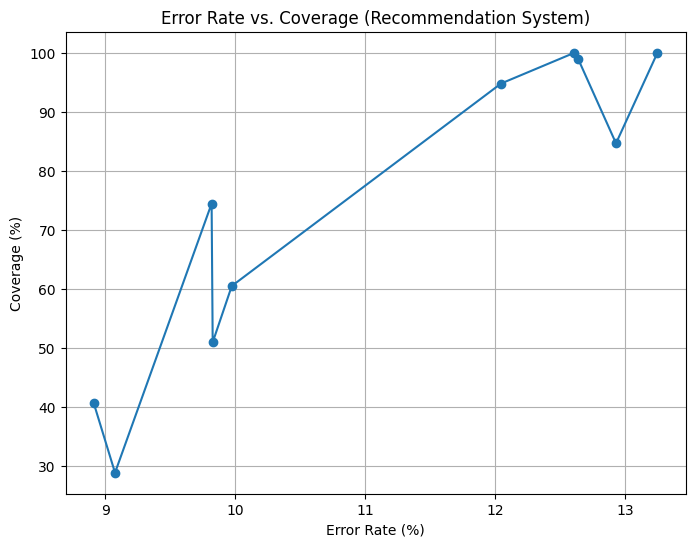

In [41]:
# Run evaluation
evaluate_recommendation_system(
    model=model,
    query_dataset=merged_test_dataset,
    support_dataset=merged_support_dataset,
    device=device,
    k=3,
    thresholds=np.linspace(0.0, 0.9, 10),
    num_queries=3600 # Datasets have around 3650 entries each
)


## Task 4


In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset